 # Predicting Brain Strokes

In [74]:
import sqlalchemy
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


# Database Setup
engine = create_engine("sqlite:///../resources/stroke_data.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

#test view all classes found by automap
Base.classes.keys()

conn = engine.connect()

#populate obesity table
stroke_df = pd.read_sql("SELECT * FROM stroke_data", conn)

stroke_df.head()

,?,age,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,1.040584334185826,2.723410903530197,1.193238162209789,0,1,0,1,0,0,0,1,0,1,0,0,1
1,1,1.614270327485722,-0.0005227665986433442,0.5893896105370293,0,1,0,1,0,0,1,0,0,0,1,0,1
2,2,0.24624988192443203,1.4485291841720218,0.8692218661902591,0,1,0,1,0,0,0,1,0,0,0,1,1
3,3,1.5701406356934222,1.5126504540805694,-0.6624915331747888,0,1,0,0,1,0,1,0,0,0,1,0,1
4,4,1.6584000192780215,1.7808947977464298,0.07390913959686891,0,1,0,1,0,0,0,1,0,1,0,0,1


In [75]:
stroke_df = stroke_df.drop(['?'], axis = 1)

In [76]:
#Define features and target
y = stroke_df["stroke"]
X = stroke_df.drop(columns="stroke")

In [77]:
#Split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(3735, 15)

In [78]:
#Logistic Regression 
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier

LogisticRegression(max_iter=200, random_state=1)

In [79]:
#Train the model
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [80]:
#First score using test data
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9502008032128514
Testing Data Score: 0.9502407704654896


In [179]:
#Make predictions
predictions = classifier.predict_proba(X_test)[:,1]>.0487
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results

# Define the file path for the CSV file
csv_file_path = "prediction_results.csv"

# Export the DataFrame to a CSV file
results.to_csv(csv_file_path, index=False)


In [180]:
predictions2 = []

for i in predictions:
    if i == True:
        predictions2.append('1')
    else:
        predictions2.append('0')


In [181]:
# Calculate the accuracy score for the test dataset.
accuracy_score(y_test, predictions2)

0.709470304975923

In [182]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, predictions2)

# Extracting values from the confusion matrix
true_negatives = confusion[0, 0]
false_positives = confusion[0, 1]
false_negatives = confusion[1, 0]
true_positives = confusion[1, 1]

print("Confusion Matrix:")
print(confusion)
print("\nTrue Negatives:", true_negatives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)
print("True Positives:", true_positives)

Confusion Matrix:
[[834 350]
 [ 12  50]]

True Negatives: 834
False Positives: 350
False Negatives: 12
True Positives: 50


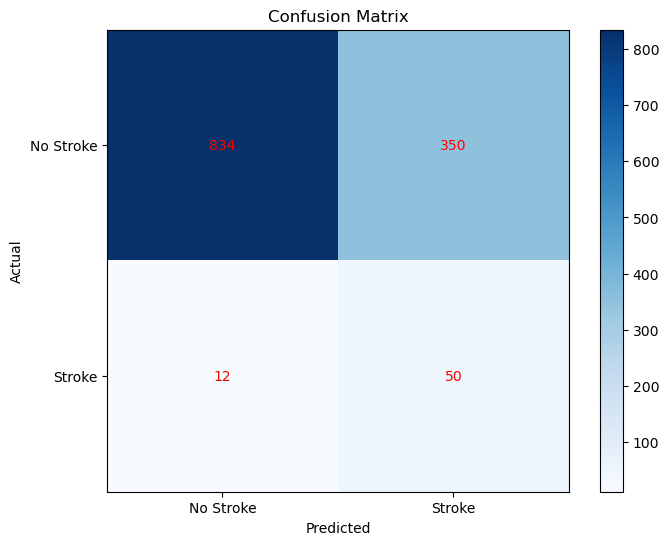

In [183]:
#Make predictions
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions2, "Actual": y_test}).reset_index(drop=True)

# Confusion Matrix
confusion = confusion_matrix(y_test, predictions2)
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks([0, 1], ["No Stroke", "Stroke"])
plt.yticks([0, 1], ["No Stroke", "Stroke"])
plt.colorbar()

# Adding annotations to the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion[i, j], ha='center', va='center', color='red')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Summary of Results

This logistic regression model takes around the highest risk third of our testing population and suggests they seek further medical testing for concerns of an oncoming stroke.

At a .0487 threshold, the model catches ~81% of strokes. A total of 400 will be sent for additional testing, and ~13.5% of those sent will go on to have a stroke, compared to ~5% for the total testing population.

In [131]:
# Classification Report
class_report = classification_report(y_test, predictions2, target_names=["No Stroke", "Stroke"])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.99      0.70      0.82      1184
      Stroke       0.13      0.82      0.22        62

    accuracy                           0.71      1246
   macro avg       0.56      0.76      0.52      1246
weighted avg       0.94      0.71      0.79      1246



In [103]:
# Getting the coefficients from the trained model
feature_names = X.columns
coefficients = classifier.coef_[0]

# Printing feature names and their corresponding coefficients
for feature, coef in zip(feature_names, coefficients):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")

Feature: age, Coefficient: 1.7247
Feature: avg_glucose_level, Coefficient: 0.2099
Feature: bmi, Coefficient: 0.0569
Feature: ever_married_No, Coefficient: 0.0348
Feature: ever_married_Yes, Coefficient: -0.0349
Feature: work_type_Govt_job, Coefficient: -0.3843
Feature: work_type_Private, Coefficient: 0.0398
Feature: work_type_Self-employed, Coefficient: -0.3971
Feature: work_type_children, Coefficient: 0.7416
Feature: Residence_type_Rural, Coefficient: -0.0724
Feature: Residence_type_Urban, Coefficient: 0.0724
Feature: smoking_status_Unknown, Coefficient: -0.0298
Feature: smoking_status_formerly smoked, Coefficient: 0.0269
Feature: smoking_status_never smoked, Coefficient: -0.1806
Feature: smoking_status_smokes, Coefficient: 0.1835


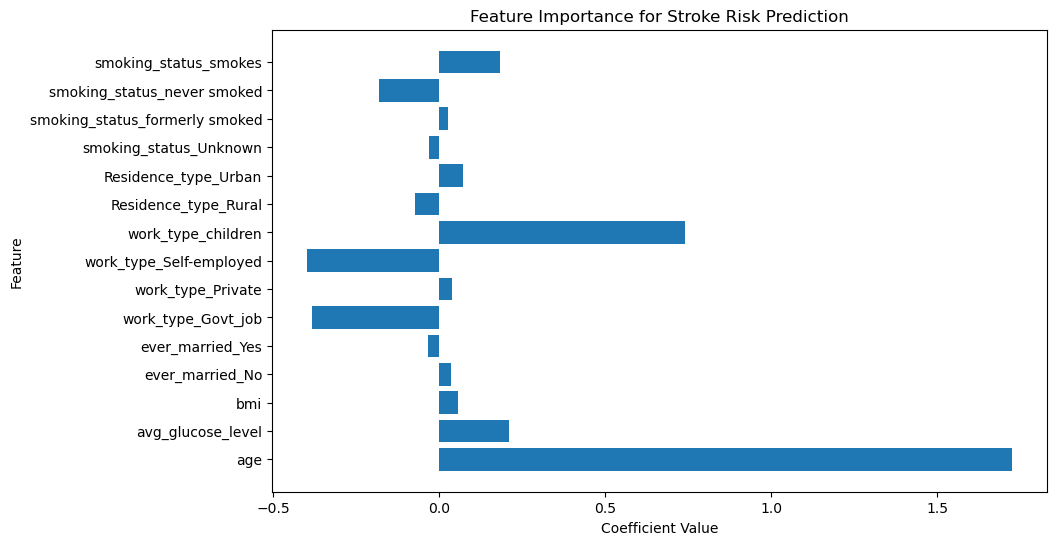

In [104]:
# Creating a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Stroke Risk Prediction')
plt.show()